# Making Predictions

Linear regression models are relative straightforward to interpret as you can derive useful insights by discovering the relationship in the data but, the story does not end there.  Using past observations, you can create an estimated model to predict unknown observations.

In this notebook, the following will be covered: 
- How to make predictions using estimated linear regression models.
- How to evaluate the predictive performance of regression models.

Throughout the notebook, predictions will be illustrated by splitting data into training and test sets.  You will estimate your models using only the training set.  Hence, you models will not see the observations in the test set, and the information in the test observations will not be used in the estimation of the models.  By holding out a portion of the data and testing on in, you can evaluate the results of your models as if it were performing on unseen real-world observations.

#### Making Predictions Using Linear Regression models

The following will demonstrate how to make predictions on the medical cost dataset from an insurance company.


In [31]:
import warnings

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse 
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
from scipy.stats.mstats import winsorize

pd.options.display.float_format = "{:.3f}".format

warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "medicalcosts"
)

In [2]:
# Load the data from the medicalcosts database
engine=create_engine(URL(**kagle), echo=True)

insurance_df = pd.read_sql("SELECT * FROM medicalcosts", con=engine)

# No need for an open connection, please close
engine.dispose()

2020-01-07 20:57:23,417 INFO sqlalchemy.engine.base.Engine select version()
2020-01-07 20:57:23,425 INFO sqlalchemy.engine.base.Engine {}
2020-01-07 20:57:23,523 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-07 20:57:23,524 INFO sqlalchemy.engine.base.Engine {}
2020-01-07 20:57:23,624 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-07 20:57:23,626 INFO sqlalchemy.engine.base.Engine {}
2020-01-07 20:57:23,677 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-07 20:57:23,680 INFO sqlalchemy.engine.base.Engine {}
2020-01-07 20:57:23,732 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-07 20:57:23,734 INFO sqlalchemy.engine.base.Engine {}
2020-01-07 20:57:23,839 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

Using the features in this dataset such as age, sex, bmi, number of children and whether this person is a smoker, you can use a linear regression model to predict the cost of that person's medical expenses.  This could be very useful information for an insurance company to accurately predict a person's potential medical costs to adjust their premiums accordingly.

In [3]:
insurance_df.head(n=10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860
5,31,female,25.740,0,no,southeast,3756.620
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.510
8,37,male,29.830,2,no,northeast,6406.410
9,60,female,25.840,0,no,northwest,28923.100


Computers love numbers and not text, so turn the "sex" and "smoker" columns into binary columns, but only keep the column that is `True`.

In [4]:
insurance_df["is_male"] = pd.get_dummies(insurance_df["sex"], drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df["smoker"], drop_first=True)

In [5]:
# Y is the target variable, in other words what are you trying to predict
Y = insurance_df["charges"]

# X is the feature set you are using to predict the medical costs
X = insurance_df[["is_male", "is_smoker", "age", "bmi", "children"]]

Now, split the data into train and test sets.  You'll be using scikit-learn's `train_test_split()` method to do this.  This method takes the features and the target as well as the test size and random state parameters as inputs.  The `train_test_split()` method uses the `test_size` parameter to decide on how much of the data will be split out as test data.  Below, set this parameter to 0.2 or 20% of the data for the test set.

In [6]:
X_train, X_test, y_train, y_test, = train_test_split(X,Y, test_size = 0.2, random_state = 465)

print(f"The number of observations in the training set is {X_train.shape[0]}")
print(f"The number of observations in the test set is {X_test.shape[0]}")

The number of observations in the training set is 1070
The number of observations in the test set is 268


Now, the features in the training and test sets are assigned to `X_train` and `X_test` respectively.  Similarly, the targets are assigned to `y_train` and `y_test`.  Next use one of the your previous models, but this time train it using only the training set.

Later, you will predict on `X_test` and use different evaluation metrics to see how closely the predictions are to `y_test

In [7]:
X_train.head()

,is_male,is_smoker,age,bmi,children
172,1,0,18,15.960,0
814,1,0,36,34.430,2
553,0,0,52,31.730,2
1239,0,0,25,42.130,1
697,1,1,41,35.750,1


Add a constant to the model, the "baseline" of the data in case all of your feature values are $0$.

In [8]:
X_train = sm.add_constant(X_train)

Now, train the model.

In [9]:
# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     629.9
Date:                Tue, 07 Jan 2020   Prob (F-statistic):          6.39e-315
Time:                        21:20:39   Log-Likelihood:                -10848.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1064   BIC:                         2.174e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.206e+04   1080.784    -11.161      0.0

As you can see from the summary table, each feature is a coefficient and each of them either increases or decreases your overall medical costs.  The information given will be used as an equation for predictions.

Now, get the predictions in `statsmodels`, the predictions will be made by calling the `predict()` function.

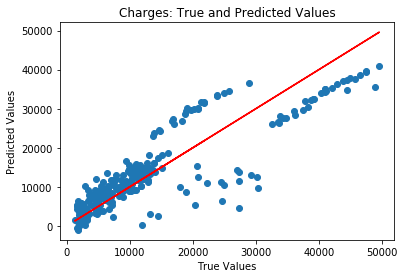

Mean absolute erro of the prediction is: 4158.061597698167
Mean squared error of the prediction is: 33814649.37955361
Root mean squared error of the prediction is: 5815.036489958908
Mean absolute percentage error of the prediction is: 42.385151969060544


In [11]:
# Add a constant to the model 
X_test = sm.add_constant(X_test)

# Make predictions on this run
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Charges: True and Predicted Values")
plt.show()

print(f"Mean absolute erro of the prediction is: {mean_absolute_error(y_test, y_preds)}")
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds)}")
print(f"Root mean squared error of the prediction is: {rmse(y_test, y_preds)}")
print(f"Mean absolute percentage error of the prediction is: {np.mean(np.abs((y_test - y_preds) / y_test))*100}")

In the graph, you see that the model predicts the lower values of the target better than the higher values.  By using visualizations like this, you can more intuitively understand the performance of the models.  But you need to find more accurate ways of assessing your models.  Above you also printed out some metrics to evaluate how good the predictions are.  Below is a discussion of the metrics

#### Evaluation metrics
When you were evaluating the training performance of a linear regression model, you use metrics like R-squared and adjusted R-squared.  R-squared measures the ration of variance in the target variable that is explained by the model.  However, when you are making predictions you care more about how close your predictions are to the target rather than the variance in the target variable.  This means that you usually use metrics other than R-squared to gauge how good the predictions are.  Here, are four of the most common ones.

**Mean Absolute Error (MAE)** is defined as the average of the absolute values of the errors between the true values and the predicted values.
$$ \frac{1}{n} \sum_{i=1}^{n}\lvert y_i-\hat{y}_i\rvert $$ 

**Mean Squared Error (MSE)** is defined as the average of the squared errors between the true values and the predicted values: 
$$ \frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2  $$

**Root Mean Squared Error (RMSE)** is defined as the square root of the MSE: 
$$ \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2}  $$

**Mean Absolute Percentage Error (MAPE)** is defined as the average of the ration of the absolute values of the errors to the true values: 
$$ \frac{1}{n} \sum_{i=1}^{n}\frac{\lvert y_i-\hat{y}_i\rvert}{y_i}  $$

Although these are different metrics, they are essentially using the difference between what you know to be correct medical cost for a person and predicted medical cost from the model.  These errors are then summed up for an overall error score.

You can use any one of the above metrics.  But there are some important points to note about them.  
- Lower values are desirable for all four metrics.  The lower the value, the better the performance of the model.
- MAE, MSE, and RMSE are in the unit of the target variable but MAPE is unitless, So MAE, MSE and RMSE are only useful if you compare different models that have the same target variable.  
- MSE and RMSE penalize large errors more than the MAE and MAPE do.  This means that MSR and RMSE are more useful when high error values are undesirable.
- For target values very close to zero, MAPE may provide a problematic picture of the performance as the ration may go to very high values, and this may distort the average.  It can also give division by zero errors if some values of the target are zero!

#### Improving on the Previous Model 

To compare with the model above, use another model where the interaction of BMI and is_smoker is included.


In [12]:
# Y is the target variable
Y = insurance_df["charges"]

# This is the interaction between bmi and is_smoker
insurance_df["bmi_is_smoker"] = insurance_df["bmi"] * insurance_df["is_smoker"]

# X is the feature set
X = insurance_df[["is_male","is_smoker","age","bmi","bmi_is_smoker"]]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print(f"The number of observations in the training set is {X_train.shape[0]}")
print(f"The number of observations in the test set is {X_test.shape[0]}")

# Add a constant to the model
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Pring the summary results
print(results.summary())

The number of observations in the training set is 1070
The number of observations in the test set is 268
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1052.
Date:                Tue, 07 Jan 2020   Prob (F-statistic):               0.00
Time:                        22:11:45   Log-Likelihood:                -10631.
No. Observations:                1070   AIC:                         2.127e+04
Df Residuals:                    1064   BIC:                         2.130e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

This second model's R-square is 0.832 and higher than the previous model, where the R-squared is 0.745.  This means that the second model's goodness of fit is higher than the previous one.   Now, make predictions.

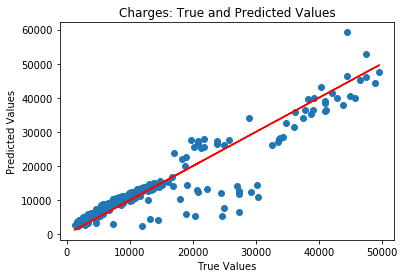

Mean absolute erro of the prediction is: 2749.4722864791793
Mean squared error of the prediction is: 19957476.990353033
Root mean squared error of the prediction is: 4467.379208255444
Mean absolute percentage error of the prediction is: 29.23705206976454


In [13]:
# Add a constant to the model
X_test = sm.add_constant(X_test)

# Make predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Charges: True and Predicted Values")
plt.show()

print(f"Mean absolute erro of the prediction is: {mean_absolute_error(y_test, y_preds)}")
print(f"Mean squared error of the prediction is: {mse(y_test, y_preds)}")
print(f"Root mean squared error of the prediction is: {rmse(y_test, y_preds)}")
print(f"Mean absolute percentage error of the prediction is: {np.mean(np.abs((y_test - y_preds) / y_test))*100}")

The test set performance of the second model is better than the previous one with respect to all of the four metrics you use! Compared to the previous model, this second model seems to better predict high values of the target variable.  It also seems that the second model better predicts low values because the points are more tightly clustered around the red line.

### Assignment

In this exercise, you'll predict house prices using your model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **housing prices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

Please submit a link your work notebook. This is not a graded checkpoint, but you should discuss your solutions with your mentor. Also, when you're done, compare your work to [this example solution](https://github.com/Thinkful-Ed/machine-learning-regression-problems/blob/master/notebooks/6.solution_making_predictions.ipynb).

In [14]:
import warnings

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error 
from statsmodels.tools.eval_measures import mse, rmse 
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 

pd.options.display.float_format = "{:3f}".format
warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "houseprices"
)

In [17]:
# Load the data from the "houseprices" database
engine=create_engine(URL(**kagle), echo=True)

houses_raw=pd.read_sql_query("SELECT * FROM houseprices", con=engine)

engine.dispose()

2020-01-08 08:02:50,034 INFO sqlalchemy.engine.base.Engine select version()
2020-01-08 08:02:50,037 INFO sqlalchemy.engine.base.Engine {}
2020-01-08 08:02:50,173 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-08 08:02:50,176 INFO sqlalchemy.engine.base.Engine {}
2020-01-08 08:02:50,314 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-08 08:02:50,316 INFO sqlalchemy.engine.base.Engine {}
2020-01-08 08:02:50,383 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-08 08:02:50,386 INFO sqlalchemy.engine.base.Engine {}
2020-01-08 08:02:50,463 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-08 08:02:50,466 INFO sqlalchemy.engine.base.Engine {}
2020-01-08 08:02:50,570 INFO sqlalchemy.engine.base.Engine SELECT * FROM houseprices
2020-01-08 08:02:50,573 INFO sqlalchemy.engine.base.Engine {}


In [18]:
houses_working = houses_raw.copy()

In [19]:
houses_df = houses_working[["neighborhood","overallqual","lotarea",
                            "totalbsmtsf","firstflrsf","grlivarea",
                            "totrmsabvgrd","garagecars","saleprice"]]

In [20]:
houses_df.describe()

,overallqual,lotarea,totalbsmtsf,firstflrsf,grlivarea,totrmsabvgrd,garagecars,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,6.099315,10516.828082,1057.429452,1162.626712,1515.463699,6.517808,1.767123,180921.195890
std,1.382997,9981.264932,438.705324,386.587738,525.480383,1.625393,0.747315,79442.502883
min,1.000000,1300.000000,0.000000,334.000000,334.000000,2.000000,0.000000,34900.000000
25%,5.000000,7553.500000,795.750000,882.000000,1129.500000,5.000000,1.000000,129975.000000
50%,6.000000,9478.500000,991.500000,1087.000000,1464.000000,6.000000,2.000000,163000.000000
75%,7.000000,11601.500000,1298.250000,1391.250000,1776.750000,7.000000,2.000000,214000.000000
max,10.000000,215245.000000,6110.000000,4692.000000,5642.000000,14.000000,4.000000,755000.000000


In [21]:
houses_df.describe(include=["O"])

,neighborhood
count,1460
unique,25
top,NAmes
freq,225


In [22]:
# Create a set of dummies for the neighborhood variable, prefix the dummies with "neighborhood"
houses_df = pd.concat([houses_df, pd.get_dummies(houses_df["neighborhood"], prefix="neighborhood",drop_first=True)], axis=1)

# Create a set of dumies for the overallqual variable, previs the dummies with "overallqual"
houses_df = pd.concat([houses_df, pd.get_dummies(houses_df["overallqual"], prefix="overallqual",drop_first=True)], axis=1)

In [23]:
# Get a list of column names to be used for feature consideration
feature_names = houses_df.iloc[:,2:].columns.to_list()

# Pop saleprice from the list of feature_names
feature_names.pop(6)

'saleprice'

In [24]:
# Y is the target variable
Y = houses_df["saleprice"]

# X is the feature set
X = houses_df[feature_names]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

print(f"The number of observations in the training set is {X_train.shape[0]}")
print(f"The number of observations in the test set is {X_test.shape[0]} \n")

# Add a constant to the model
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

The number of observations in the training set is 1168
The number of observations in the test set is 292 

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     148.5
Date:                Wed, 08 Jan 2020   Prob (F-statistic):               0.00
Time:                        08:19:26   Log-Likelihood:                -13766.
No. Observations:                1168   AIC:                         2.761e+04
Df Residuals:                    1128   BIC:                         2.781e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------

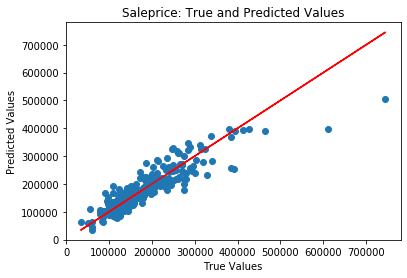

Mean Absolute Error (MAE) of the prediction is: 23142.844991837042
Mean Squared Error (MSE) of the predictions is: 1287150589.2922657
Root Mean Squared Error (RMSE) of the prediction is: 35876.880986120654
Mean Absolute Percentage Error (MAPE) of the prediction is: 13.09168530892422


In [28]:
# Add a constant to the model 
X_test = sm.add_constant(X_test)

# Make initial predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Saleprice: True and Predicted Values")
plt.show()

print(f"Mean Absolute Error (MAE) of the prediction is: {mean_absolute_error(y_test, y_preds)}")
print(f"Mean Squared Error (MSE) of the predictions is: {mse(y_test, y_preds)}")
print(f"Root Mean Squared Error (RMSE) of the prediction is: {rmse(y_test, y_preds)}")
print(f"Mean Absolute Percentage Error (MAPE) of the prediction is: {np.mean(np.abs((y_test - y_preds) / y_test)) * 100}")

Looking at the predictions visualization, the model does a pretty good job of predicting saleprice though it's effectiveness diminishes as the price increases.  The model tends to underestimate the saleprice. What do the metrics say? The MAE and RMSE are both signifigantly lower in relative units.  The MSE on the on the other hand is substantially higher.  I believe this means that the errors that are measured by this metric are substantially greater in this model.

#### _In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables._

In [122]:
houses_winsorized = houses_working[["neighborhood","overallqual","lotarea",
                                    "totalbsmtsf","firstflrsf","grlivarea",
                                    "totrmsabvgrd","garagecars","garagearea","saleprice"]]

# Winsorized values were derrived during EDA
winsorize_vals = dict(
    lotarea=(0.10,0.05),
    totalbsmtsf=(0.10,0.05),
    firstflrsf=(0.0,0.1),
    grlivarea=(0.0,0.1),
    totrmsabvgrd=(0.0,0.1),
    garagecars=(0.0,0.1),
    garagearea=(0.0,0.1),
    saleprice=(0.0,0.1)
)

# Add a column for each of the winsorized values
for i, (k,v) in enumerate(winsorize_vals.items()):
    houses_winsorized[f"{k}_winsorized"] = winsorize(houses_winsorized[k], v)

In [123]:
# Create a set of dummies for the neighborhood variable, prefix the dummies with "neighborhood"
houses_winsorized = pd.concat([houses_winsorized, pd.get_dummies(houses_winsorized["neighborhood"], prefix="neighborhood",drop_first=True)], axis=1)

# Create a set of dumies for the overallqual variable, previs the dummies with "overallqual"
houses_winsorized = pd.concat([houses_winsorized, pd.get_dummies(houses_winsorized["overallqual"], prefix="overallqual",drop_first=True)], axis=1)

In [124]:
# Add an interaction between garagecars and garagearea
houses_winsorized["garagecars_garagearea"] = houses_winsorized["garagecars"] * houses_winsorized["garagearea"]

# Get a list of column names to be used for feature consideration
feature_names = houses_winsorized.iloc[:,2:].columns.to_list()

# Pop saleprice from the list of feature_names
feature_names.pop(15)

# Get the final list of feature columns for the model
feature_names = feature_names[8:]

In [125]:
# Y is the target variable
Y = houses_winsorized["saleprice_winsorized"]

# X is the feature set
X = houses_winsorized[feature_names]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print(f"The number of observations in the training set is {X_train.shape[0]}, {X_train.shape[1]}")
print(f"The number of observations in the test set is {X_test.shape[0]}, {X_test.shape[1]} \n")

# Add a constant to the model
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodel
results = sm.OLS(y_train,X_train).fit()

# Print the results
print(results.summary())

The number of observations in the training set is 1168, 41
The number of observations in the test set is 292, 41 

                             OLS Regression Results                             
Dep. Variable:     saleprice_winsorized   R-squared:                       0.872
Model:                              OLS   Adj. R-squared:                  0.868
Method:                   Least Squares   F-statistic:                     187.4
Date:                  Wed, 08 Jan 2020   Prob (F-statistic):               0.00
Time:                          10:29:24   Log-Likelihood:                -13266.
No. Observations:                  1168   AIC:                         2.662e+04
Df Residuals:                      1126   BIC:                         2.683e+04
Df Model:                            41                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0

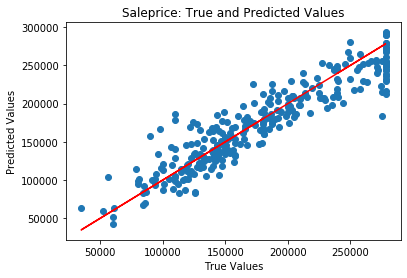

Mean Absolute Error (MAE) of the prediction is: 17252.823573835452
Mean Squared Error (MSE) of the predictions is: 521000044.0965901
Root Mean Squared Error (RMSE) of the prediction is: 22825.42538697998
Mean Absolute Percentage Error (MAPE) of the prediction is: 11.166771155311565


In [126]:
# Add a constant
X_test = sm.add_constant(X_test)

# Make predictions
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Saleprice: True and Predicted Values")
plt.show()

print(f"Mean Absolute Error (MAE) of the prediction is: {mean_absolute_error(y_test, y_preds)}")
print(f"Mean Squared Error (MSE) of the predictions is: {mse(y_test, y_preds)}")
print(f"Root Mean Squared Error (RMSE) of the prediction is: {rmse(y_test, y_preds)}")
print(f"Mean Absolute Percentage Error (MAPE) of the prediction is: {np.mean(np.abs((y_test - y_preds) / y_test)) * 100}")

This model is a much better predicter of sale prices than the first version.  MAE, MSE, & RMSE are all much lower, on a unit basis, than in the first model.  The MAPE also saw an improvement in this model.